In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlp
mlp.rcParams['figure.figsize'] = (15, 7)

In [15]:
train_data = pd.read_csv('rosneft/train_data.csv')
gtm = pd.read_csv('rosneft/gtm.csv')
coords = pd.read_csv('rosneft/coords.csv')
sampl_sab = pd.read_csv('rosneft/sample_submission.csv')

In [16]:
train_data["MEASURED_IN_DATE"] = pd.to_datetime(train_data["MEASURED_IN_DATE"])

In [17]:
to_year_plot = train_data.groupby('MEASURED_IN_DATE').mean().loc['2022']

In [18]:
data_to_test = np.array(train_data["LIQ_RATE"][:15000])

Text(0.5, 1.0, 'AAAAA CHURKI ZAEBALI LIQ_RATE')

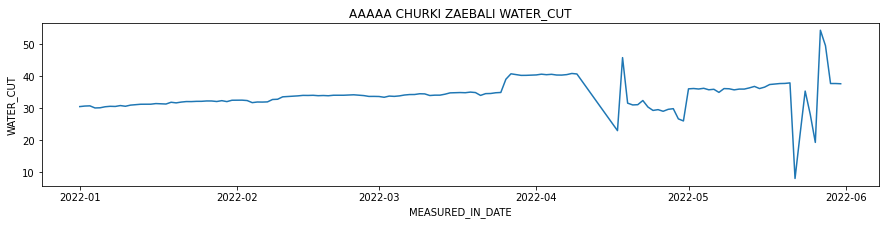

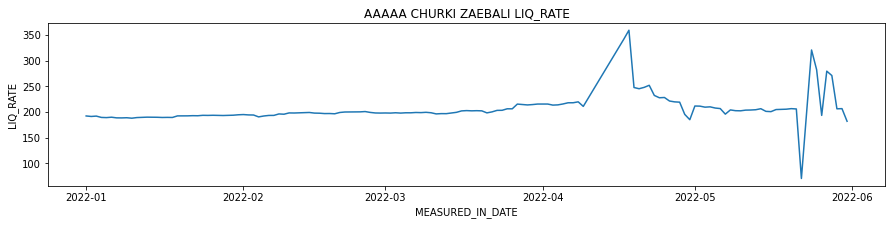

In [19]:
plt.figure(figsize =(15, 3))
sns.lineplot(data=to_year_plot, x = 'MEASURED_IN_DATE', y = 'WATER_CUT')
plt.title('AAAAA CHURKI ZAEBALI WATER_CUT')
plt.figure(figsize =(15, 3))
sns.lineplot(data=to_year_plot, x = 'MEASURED_IN_DATE', y = 'LIQ_RATE')
plt.title('AAAAA CHURKI ZAEBALI LIQ_RATE')

In [20]:
train228 = pd.read_csv('rosneft/train228.csv')
# train228 = train228.drop(columns=['WELL_NAME'])
train228['MEASURED_IN_DATE'] = pd.to_datetime(train228['MEASURED_IN_DATE'])

In [21]:
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from sklearn.metrics import mean_absolute_error

forecast_length = 1000
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))

input_data_LIQ_RATE = InputData(idx=np.arange(0, len(data_to_test)), features=data_to_test,
                       target=data_to_test, task=task,
                       data_type=DataTypesEnum.ts)

In [22]:
train_input, predict_input = train_test_data_setup(input_data_LIQ_RATE)

In [23]:
from fedot.api.main import Fedot

def get_two_branches_pipeline(lagged_param_1=10, lagged_param_2=10,
                              model_1='ridge', model_2='ridge', model_3='ridge'):
    """
    Pipeline looking like this
    lagged -> model_1 \
                       \
                        model_3 -> final forecast
                       /
    lagged -> model_2 /
    """
    # First level
    node_lagged_1 = PrimaryNode('lagged')
    node_lagged_1.custom_params = {'window_size': lagged_param_1}
    node_lagged_2 = PrimaryNode('lagged')
    node_lagged_2.custom_params = {'window_size': lagged_param_2}

    # Second level
    node_second_1 = SecondaryNode(model_1, nodes_from=[node_lagged_1])
    node_second_2 = SecondaryNode(model_2, nodes_from=[node_lagged_2])

    # Third level - root node
    node_final = SecondaryNode(model_3, nodes_from=[node_second_1, node_second_2])
    pipeline = Pipeline(node_final)
    
    return pipeline

In [24]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()

{'depth': 3, 'length': 5, 'nodes': [ridge, ridge, lagged, ridge, lagged]}


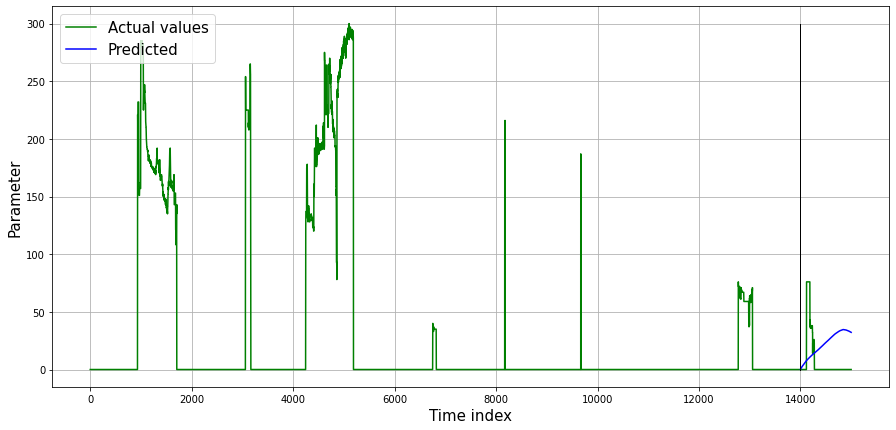

Mean absolute error: 26.561


In [25]:
pipeline = get_two_branches_pipeline(100, 20)
print(pipeline)
pipeline.fit(train_input)

output = pipeline.predict(predict_input)
forecast = np.ravel(np.array(output.predict))

plot_results(actual_time_series = data_to_test,
             predicted_values = forecast, 
             len_train_data = len(data_to_test)-forecast_length)

print(f'Mean absolute error: {mean_absolute_error(predict_input.target, forecast):.3f}')

In [26]:
# from fedot.core.pipelines.tuning.unified import PipelineTuner

# init_pipeline = get_two_branches_pipeline()

# pipeline_tuner = PipelineTuner(pipeline=init_pipeline, 
#                                task=task,
#                                iterations=50)

# tuned_pipeline = pipeline_tuner.tune_pipeline(input_data=train_input,
#                                               loss_function=mean_absolute_error,
#                                               loss_params=None)

In [27]:
# tuned_output = tuned_pipeline.predict(predict_input)
# tuned_forecast = np.ravel(np.array(tuned_output.predict))

# plot_results(actual_time_series = data_to_test,
#              predicted_values = tuned_forecast, 
#              len_train_data = len(data_to_test)-forecast_length)

# # Print MAE metric
# print(f'Mean absolute error: {mean_absolute_error(predict_input.target, tuned_forecast):.3f'}

Advanced approach (сore-based example)

Time series cross validation for pipeline composing was applied.


INFO:fedot.core.composer.gp_composer.gp_composer:Time series cross validation for pipeline composing was applied.


For ts cross validation validation_blocks number was changed from None to 3 blocks


INFO:fedot.core.composer.gp_composer.gp_composer:For ts cross validation validation_blocks number was changed from None to 3 blocks


Number of used CPU's: 1


INFO:individuals evaluation logger:Number of used CPU's: 1
Generations:   5%|▌         | 1/20 [00:00<?, ?gen/s]

Number of used CPU's: 1


INFO:individuals evaluation logger:Number of used CPU's: 1


Best metric is 36.89307132494073


INFO:fedot.core.composer.gp_composer.gp_composer:Best metric is 36.89307132494073
Generations:   5%|▌         | 1/20 [03:09<?, ?gen/s]

Result:



INFO:fedot.core.composer.gp_composer.gp_composer:Result:


Best metric is 36.89307132494073


INFO:fedot.core.composer.gp_composer.gp_composer:Best metric is 36.89307132494073


Composition time: 6.29 min


INFO:fedot.core.composer.gp_composer.gp_composer:Composition time: 6.29 min


Algorithm was terminated due to processing time limit


INFO:fedot.core.composer.gp_composer.gp_composer:Algorithm was terminated due to processing time limit


GP composition finished


INFO:fedot.core.composer.gp_composer.gp_composer:GP composition finished


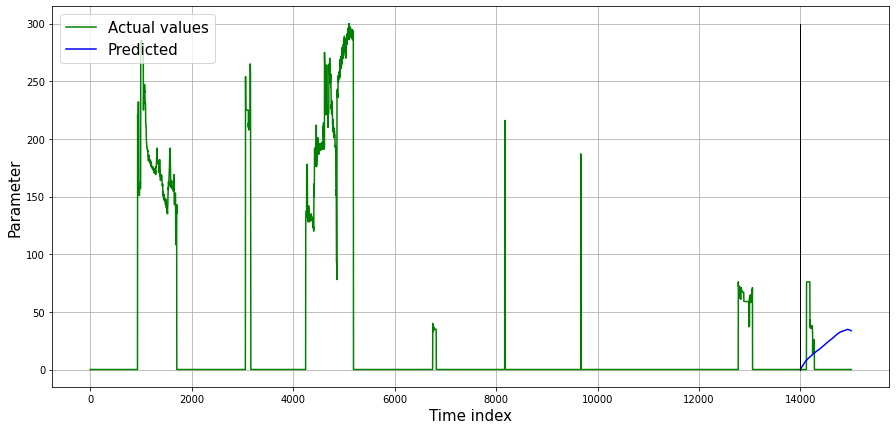

Mean absolute error: 26.013


In [30]:
import datetime

from fedot.core.data.data import InputData
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.optimisers.gp_comp.operators.mutation import MutationTypesEnum
from fedot.core.composer.gp_composer.specific_operators import parameter_change_mutation
from fedot.core.composer.composer_builder import ComposerBuilder
from fedot.core.composer.gp_composer.gp_composer import PipelineComposerRequirements
from fedot.core.optimisers.gp_comp.operators.inheritance import GeneticSchemeTypesEnum
from fedot.core.optimisers.gp_comp.gp_optimiser import GPGraphOptimiserParameters
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum
from fedot.core.repository.quality_metrics_repository import MetricsRepository, RegressionMetricsEnum\

primary_operations = ['sparse_lagged', 'lagged', 'smoothing', 'gaussian_filter', 'ar']
secondary_operations = ['sparse_lagged', 'lagged', 'ridge', 'lasso', 'knnreg', 'dtreg', 
                        'linear', 'scaling', 'ransac_lin_reg', 'ransac_non_lin_reg', 
                        'rfe_lin_reg', 'rfe_non_lin_reg']

timeout = datetime.timedelta(minutes=1)
composer_requirements = PipelineComposerRequirements(
    primary=primary_operations,
    secondary=secondary_operations, 
    max_arity=3,
    max_depth=8, 
    pop_size=10, 
    num_of_generations=20,
    crossover_prob=0.8,
    mutation_prob=0.8,
    timeout=timeout, 
    cv_folds=2)

mutation_types = [parameter_change_mutation, MutationTypesEnum.simple, MutationTypesEnum.reduce]
optimiser_parameters = GPGraphOptimiserParameters(mutation_types=mutation_types)

init_pipeline = get_two_branches_pipeline()

metric_function = MetricsRepository().metric_by_id(RegressionMetricsEnum.MAE)
builder = ComposerBuilder(task=task). \
    with_optimiser(parameters=optimiser_parameters).\
    with_requirements(composer_requirements).\
    with_metrics(metric_function).with_initial_pipelines([init_pipeline])
composer = builder.build()

obtained_pipeline = composer.compose_pipeline(data=train_input, is_visualise=False)

# Fit pipeline on the entire dataset
obtained_pipeline.fit(train_input)

# Make prediction
obtained_output = obtained_pipeline.predict(predict_input)
obtained_forecast = np.ravel(np.array(obtained_output.predict))


plot_results(actual_time_series = data_to_test,
             predicted_values = obtained_forecast, 
             len_train_data = len(data_to_test)-forecast_length)

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(predict_input.target, obtained_forecast):.3f}')


In [32]:
from fedot.core.pipelines.tuning.unified import PipelineTuner

# init_pipeline = get_two_branches_pipeline()

pipeline_tuner = PipelineTuner(pipeline=obtained_pipeline, 
                               task=task,
                               iterations=50)

tuned_pipeline = pipeline_tuner.tune_pipeline(input_data=train_input,
                                              loss_function=mean_absolute_error,
                                              loss_params=None)

Hyperparameters optimization start


INFO:fedot.core.pipelines.tuning.tuner_interface:Hyperparameters optimization start


  4%|▍         | 2/50 [06:49<2:43:52, 204.85s/trial, best loss: 43.084559723282084]
Hyperparameters optimization finished


INFO:fedot.core.pipelines.tuning.tuner_interface:Hyperparameters optimization finished


Return init pipeline due to the fact that obtained metric 43.085 bigger than initial (+ 5% deviation) 39.862


INFO:fedot.core.pipelines.tuning.tuner_interface:Return init pipeline due to the fact that obtained metric 43.085 bigger than initial (+ 5% deviation) 39.862


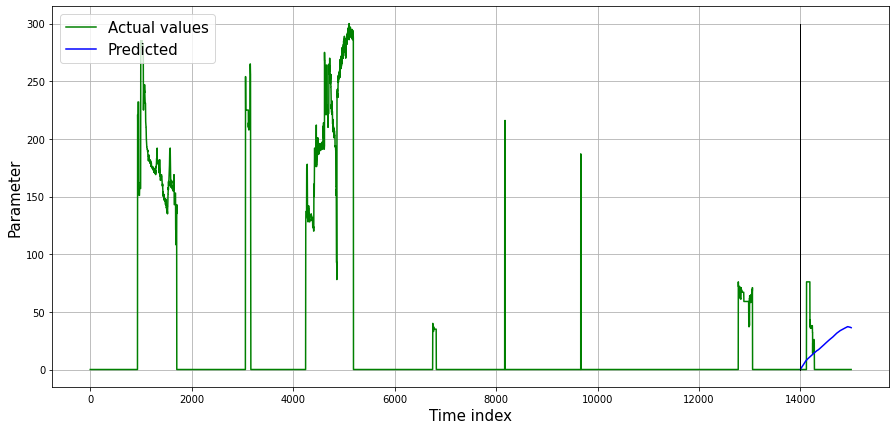

Mean absolute error: 26.013


In [34]:
tuned_output = tuned_pipeline.predict(predict_input)
tuned_forecast = np.ravel(np.array(tuned_output.predict))

plot_results(actual_time_series = data_to_test,
             predicted_values = tuned_forecast, 
             len_train_data = len(data_to_test)-forecast_length)

# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(predict_input.target, obtained_forecast):.3f}')

In [43]:
pipeline = get_two_branches_pipeline()
time_series = np.array(train_data["LIQ_RATE"][80000:])
forecast_length = 120
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))

input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series,
                       target=time_series,
                       task=task,
                       data_type=DataTypesEnum.ts)

train_input, predict_input = train_test_data_setup(input_data)

In [44]:
pipeline 

{'depth': 3, 'length': 5, 'nodes': [ridge, ridge, lagged, ridge, lagged]}

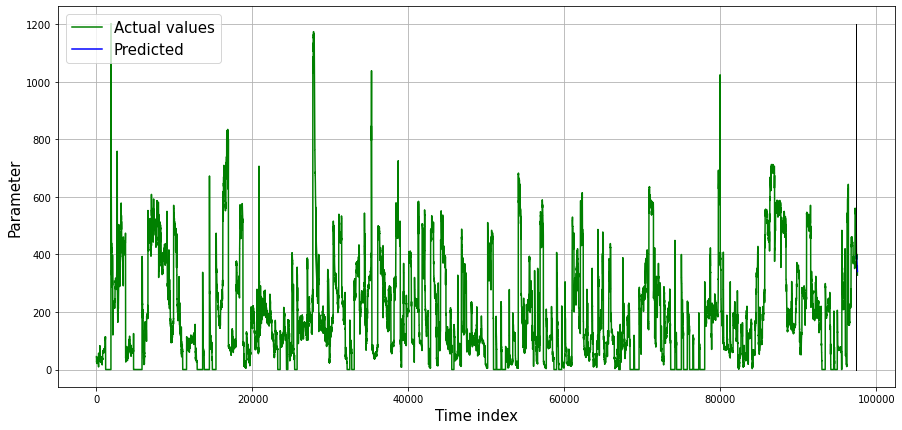

In [45]:
# Fit pipeline
pipeline.fit(train_input)

# Make forecast
output = pipeline.predict(predict_input)
forecast = np.ravel(np.array(output.predict))

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = forecast, 
             len_train_data = len(time_series)-forecast_length)

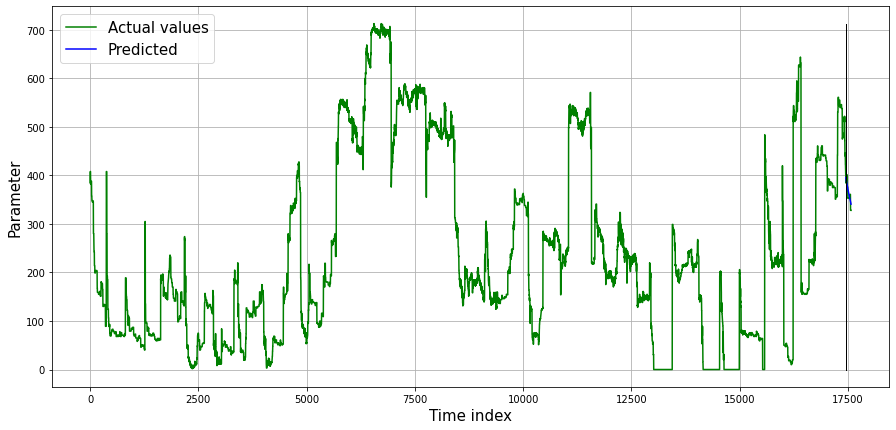

In [49]:
plot_results(actual_time_series = time_series[80000:],
             predicted_values = forecast, 
             len_train_data = len(time_series[80000:])-forecast_length)

In [50]:
print(f'Mean absolute error: {mean_absolute_error(predict_input.target, forecast):.3f}')

Mean absolute error: 8.566


In [56]:
from fedot.core.pipelines.ts_wrappers import out_of_sample_ts_forecast

ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=input_data,
                                         horizon=120)

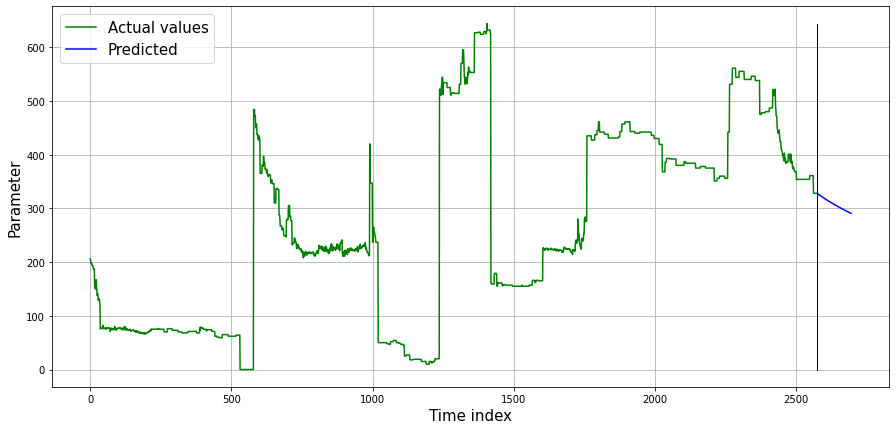

In [60]:
plot_results(actual_time_series = time_series[95000:],
             predicted_values = ts_predicted, 
             len_train_data = len(time_series[95000:]))